## Homework 3

In [0]:
from zlib import crc32
theory = crc32('Самохина'.lower().encode('utf-8'))%5+1
practice = crc32('Samokhina'.lower().encode('utf-8'))%3+1

In [2]:
theory, practice

(3, 3)

### Practice. Ex.3

Реализовать пример удаления параметров для логистической регрессии на MNIST и сравнить качество со случайным удалением параметров (ось X — процент удаленных параметров) с использованием Optimal Brain Damage.


#### Подключение библиотек

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt


from torchvision import datasets
from torch.utils.data import Dataset, TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer

from tqdm import tqdm_notebook as tqdm

import pickle

#### Загрузка данных 

In [0]:
mnist = datasets.MNIST('./mnist', train=False, download=True, transform=None)
X_test, y_test = mnist.data, mnist.targets

mnist = datasets.MNIST('./mnist', train=True, download=True, transform=None)
X_train, y_train = mnist.data, mnist.targets


In [0]:
X_train = X_train.reshape([X_train.shape[0], -1]).float()
X_test = X_test.reshape([X_test.shape[0], -1]).float()

#### Вспомогательные функции


##### Градиент и гессиан
Взято с https://github.com/mariogeiger/hessian

In [0]:
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])

def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

In [0]:
def resized_hess(model, hess):
    bias = 0
    resized = []
    for p in tqdm(model.parameters()):
        p_size = torch.tensor(p.size()).prod()
        resized.append(hess[bias:bias+p_size].view_as(p))
        bias+=p_size
    return resized

##### Обучение моделей

In [0]:
def train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function):
        model.zero_grad()
        
        output = model(batch_of_x)
        
        loss = loss_function(output, batch_of_y)
        loss.backward()
        optimizer.step()
     
        return
    
def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)

    return

def train_model(epochs, batch_size, dataset, model, loss_function, optimizer, progress = None):
    iterations = range(epochs)
    if progress is not None:
        iterations = progress(iterations)

    for i in iterations:
        batch_generator = DataLoader(dataset = dataset, batch_size = batch_size, shuffle=True)
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optimizer)
    
    return

##### Модель

In [0]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim=50, output_dim=10, device='cpu'):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.linear = torch.nn.Linear(input_dim, output_dim)        
        self.to(device)
        
    def forward(self, input):
        output = input
        output = F.relu(output)
        return self.linear(output)

##### Оптимизатор

Использован source code for torch.optim.Adam 

In [0]:
class Adam(Optimizer):
#Adam Source code    
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    

#Added functions
 
    def pruning(self, percentage = 0.1, method = 'random', **argv):
        if method == 'random':
            for group in self.param_groups:
                 for p in group['params']:
                    param_state = self.state[p]
                    if 'prune' not in param_state:
                        param_state['prune'] = torch.ones_like(p)

                    p_vector = p.view(-1)
                    prune_vector = param_state['prune'].view(-1)
                    if int(percentage*len(p_vector)) > 0:
                        
                        prune_vector[torch.randperm(p_vector.shape[0])[:int(percentage*len(p_vector))]] = 0
                        p_vector.data.mul_(prune_vector)            

        elif method == 'OBD':
            if argv['hessian'] is None:
                pass
            else:
                for group in self.param_groups:
                    for p, h in zip(group['params'], argv['hessian']):
                        param_state = self.state[p]
                        if 'prune' not in param_state:
                            param_state['prune'] = torch.ones_like(p)

                        p_vector = p.view(-1)
                        score = (p*h).view(-1)
                        prune_vector = param_state['prune'].view(-1)
                        if int(percentage*len(p_vector)) > 0:
                            
                            prune_vector[torch.sort(score)[1][:int(percentage*len(p_vector))]] = 0
                            p_vector.data.mul_(prune_vector)
            pass

        else:
            raise ValueError("Unsupported method: {}".format(method))

#Modified step function
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                #some modifications in step to use our pruning methods:
                d_p = p.grad.data.detach()
                param_state = self.state[p]
    
                if 'prune' in param_state:
                    prune = param_state['prune']
                else:
                    prune = torch.ones_like(p)
                    param_state['prune'] = prune
                #end of mofifications                
                
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                
                # State initialization
                if 'step' not in state:
                    state['step'] = 0
                # Exponential moving average of gradient values
                if 'exp_avg' not in state:
                    state['exp_avg'] = torch.zeros_like(p.data)
                # Exponential moving average of squared gradient values
                if 'exp_avg_sq' not in state:
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(-step_size, prune*exp_avg, denom)
    
        return loss


#### Обучение модели

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.CrossEntropyLoss()

In [0]:
train_device = TensorDataset(X_train.to(device), y_train.to(device))
test_device = TensorDataset(X_test.to(device), y_test.to(device))

In [0]:
model = LogisticRegression(input_dim=X_train.shape[1], output_dim = 10, device=device)
optimizer = Adam(model.parameters())

In [14]:
train_model(epochs = 100,
        batch_size = 64,
        dataset = train_device,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer,
        progress = tqdm
       )

In [0]:
output = model(train_device[:][0])
loss = loss_function(output, train_device[:][1])

In [16]:
hess = hessian(loss, model.parameters())
hs = resized_hess(model, torch.diag(hess))

In [0]:
pcs = np.linspace(0, 1, 20)
k_avg = 5

In [56]:
random_score = []
for percentage in tqdm(pcs):
    list_score = []
    for _ in range(k_avg):
        optimizer = Adam(model.parameters())
        optimizer.pruning(percentage=percentage, method='random', hessian=hs)
        train_model(epochs=2, batch_size=64, dataset=train_device, model=model, loss_function = loss_function, optimizer = optimizer)

        output = model(test_device[:][0])
        output.sum(dim = 1)
        answ = torch.argmax(torch.softmax(output, dim=1), dim=1)

        list_score.append(float((test_device[:][1] == answ).sum()) / test_device[:][1].shape[0])
    random_score.append(list_score)
  
random_score = np.array(random_score)


In [57]:
OBD_score = []
for percentage in tqdm(pcs):
    optimizer = Adam(model.parameters())
    optimizer.pruning(percentage=percentage, method='OBD', hessian=hs)

    train_model(epochs=2, batch_size=64, dataset=train_device, model=model, loss_function=loss_function, optimizer=optimizer)

    output = model(test_device[:][0])
    output.sum(dim=1)
    answ = torch.argmax(torch.softmax(output, dim=1), dim=1)

    OBD_score.append(float((test_device[:][1] == answ).sum()) / test_device[:][1].shape[0])
  
OBD_score = np.array(OBD_score)

In [0]:
random_mean = np.mean(random_score, axis = 1)
random_std = np.std(random_score, axis = 1)

#### Сравнение методов удаления параметров

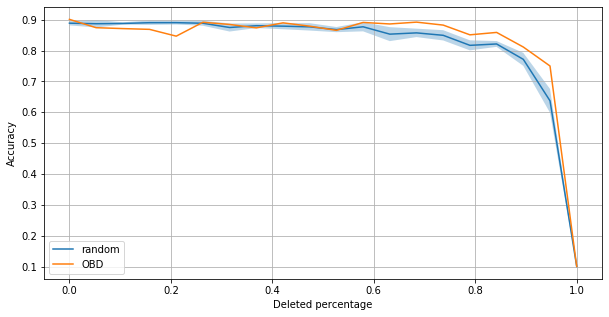

In [61]:
plt.figure(figsize = (10, 5))
plt.plot(pcs, random_mean, label='random')
plt.fill_between(pcs, random_mean-random_std, random_mean+random_std, alpha=0.3)

plt.plot(pcs, OBD_score, label='OBD')

plt.legend(loc='lower left')
plt.grid()

plt.xlabel('Deleted percentage')
plt.ylabel('Accuracy')
plt.show()

Из графика видно, что оба метода дают хорошее качество (>80%) при удалении до 80% параметров. Однако метод optimal brain damage позволяет без снижения качества ниже 80% удалить до 90% параметров и, более того, показывает более высокое качество при удалении свыше 60% параметров по сравнению со случайным удалением 